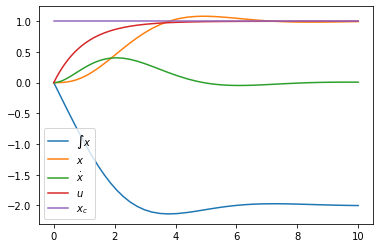

In [3]:
# simupy/examples/pid.py

import numpy as np
from scipy import signal, linalg
from simupy.systems import LTISystem, SystemFromCallable
from simupy.block_diagram import BlockDiagram
import matplotlib.pyplot as plt

# construct second order system state and input matrices
m = 1
d = 1
b = 1
k = 1
Ac = np.c_[[0, -k/m], [1, -b/m]]
Bc = np.r_[0, d/m].reshape(-1, 1)

# augment state and input matrices to add integral error state
A_aug = np.hstack((np.zeros((3,1)), np.vstack((np.r_[1, 0], Ac))))
B_aug = np.hstack(( np.vstack((0, Bc)), -np.eye(3,1)))

# construct system
aug_sys = LTISystem(A_aug, B_aug,)

# construct PID system
Kc = 1
tau_I = 1
tau_D = 1
K = -np.r_[Kc/tau_I, Kc, Kc*tau_D].reshape((1,3))
pid = LTISystem(K)

# construct reference
ref = SystemFromCallable(lambda *args: np.ones(1), 0, 1)

# create block diagram
BD = BlockDiagram(aug_sys, pid, ref)
BD.connect(aug_sys, pid) # PID requires feedback
BD.connect(pid, aug_sys, inputs=[0]) # PID output to system control input
BD.connect(ref, aug_sys, inputs=[1]) # reference output to system command input

res = BD.simulate(10) # simulate

# plot
plt.figure()
plt.plot(res.t, res.y[:, 0], label=r'$\int x$')
plt.plot(res.t, res.y[:, 1], label='$x$')
plt.plot(res.t, res.y[:, 2], label=r'$\dot{x}$')
plt.plot(res.t, res.y[:, 3], label='$u$')
plt.plot(res.t, res.y[:, 4], label='$x_c$')
plt.legend()
plt.show()

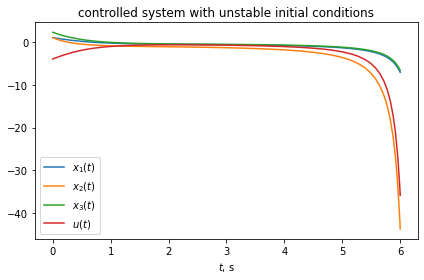

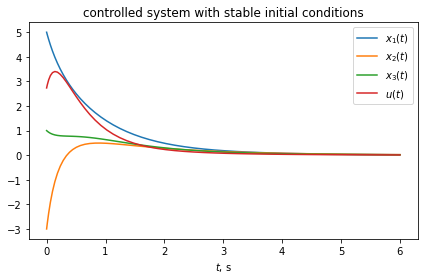

In [2]:
# simupy/examples/linearcontrol_nonlinearsys.py

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from simupy.systems import LTISystem
from simupy.systems.symbolic import DynamicalSystem, dynamicsymbols
from simupy.block_diagram import BlockDiagram
from sympy.tensor.array import Array
from numpy import matlib

legends = [r'$x_1(t)$', r'$x_2(t)$', r'$x_3(t)$', r'$u(t)$']
tF = 6

"""
This example shows the design of a linear quadratic regulator for a
nonlinear system linearized about the origin. It is stable for some initial
conditions, but not all initial conditions. The region of stability is not
dependent only on the distance from the origin.
"""

# construct system
x = Array(dynamicsymbols('x1:4'))
u = dynamicsymbols('u')
x1, x2, x3 = x
sys = DynamicalSystem(Array([-x1+x2-x3, -x1*x2-x2+u, -x1+u]), x, Array([u]))

# linearization to design LQR
t0 = 0
x0 = np.zeros((3, 1))
u0 = 0
A = sys.state_jacobian_equation_function(t0, x0, u0)
B = sys.input_jacobian_equation_function(t0, x0, u0)

# LQR gain
Q = np.matlib.eye(3)
R = np.matrix([1])
S = linalg.solve_continuous_are(A, B, Q, R,)
K = linalg.solve(R, B.T @ S).reshape(1, -1)
ctr_sys = LTISystem(-K)

# Construct block diagram
BD = BlockDiagram(sys, ctr_sys)
BD.connect(sys, ctr_sys)
BD.connect(ctr_sys, sys)

# case 1 - un-recoverable
sys.initial_condition = np.r_[1, 1, 2.25]
result1 = BD.simulate(tF)
plt.figure()
plt.plot(result1.t, result1.y)
plt.legend(legends)
plt.title('controlled system with unstable initial conditions')
plt.xlabel('$t$, s')
plt.tight_layout()
plt.show()

# case 2 - recoverable
sys.initial_condition = np.r_[5, -3, 1]
result2 = BD.simulate(tF)
plt.figure()
plt.plot(result2.t, result2.y)
plt.legend(legends)
plt.title('controlled system with stable initial conditions')
plt.xlabel('$t$, s')
plt.tight_layout()
plt.show()

In [5]:
BD